In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pathlib
import joblib
import time
from lb2jpsil import fit_utils
from scipy import optimize, integrate
from sklearn import metrics

In [2]:
## Self explanatory
save_plots = False

## Toggle plot titles (off for thesis and papers, generally speaking)
show_titles = True

## Toggle plot grid
show_grid = False

## Black and white?
black_and_white = False

## Drop event if DTF_FixJPsiLambda failed?
dtf_success = True

## Veto physical background
b0_veto = True

In [3]:
saved_models = {
    ## BALANCE
    ## Higher overtraining. Slightly better performance in test (fractions of percentage)
    'sachiel': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'balance',
        'learning_rate' : 0.010,
        'max_leaf_nodes' : 200,
        'max_iter' : 5000,
        'soft_threshold': 0.7,
        'hard_threshold': 0.9924
    },
    ## Lower ovetraining. Looks better under K-S test. Slightly worse performance in test (fractions of percentage)
    'shamshel': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'balance',
        'learning_rate' : 0.003,
        'max_leaf_nodes' : 100,
        'max_iter' : 2500,
        'soft_threshold': 0.7,
        'hard_threshold': 0.985
    },
    ## BKGSKEW
    ## From an overtraining standpoint, this is the better one of the bkgskew
    'ramiel': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'bkgskew',
        'learning_rate' : 0.003,
        'max_leaf_nodes' : 100,
        'max_iter' : 1500,
        'soft_threshold': 0.1,
        'hard_threshold': 0.656
    },
    ## This has quite more overtraining, but loses less signal
    'israfel': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'bkgskew',
        'learning_rate' : 0.015,
        'max_leaf_nodes' : 100,
        'max_iter' : 1500,
        'soft_threshold': 0.1,
        'hard_threshold': 0.71436
    },
    ## Salvatore's HBDT, for performance comparison.
    ## Somewhat similar to israfel, does not match his original HBDT
    'sandalphon': {
        'daughter_momenta': 'DTF',
        'dataset_type': 'bkgskew',
        'learning_rate' : 0.01,
        'max_leaf_nodes' : 100,
        'max_iter' : 2500,
        'soft_threshold': 0.1
    }
}

In [4]:
## Either one of the names in list(saved_models) or 'temp' for custom new model
model_to_use = 'sandalphon'

if model_to_use in saved_models:
    daughter_momenta = saved_models[model_to_use]['daughter_momenta']
    dataset_type = saved_models[model_to_use]['dataset_type']
    training_params = {key: saved_models[model_to_use][key] for key in ['learning_rate', 'max_leaf_nodes', 'max_iter']}
    soft_threshold = saved_models[model_to_use]['soft_threshold']
elif model_to_use == 'temp':
    ## Proton and pion momenta
    ## 'VF': use VF momenta
    ## 'DTF': use DTF momenta w/ JPsi m.c.
    ## 'DTFL': use DTF momenta w/ JPsi and Lambda m.c.
    ## 'NO': don't use any momenta for Lambda daughter particles
    daughter_momenta = 'DTF'

    ## Two options:
    ## 'balance': same number of training events for signal and bkg
    ## 'bkgskew' uses 4 mln events of bkg, 500k of signal
    dataset_type = 'bkgskew'

    training_params = {
        'learning_rate' : 0.003,
        'max_leaf_nodes' : 100,
        'max_iter' : 5000
    }
    
    ## Threshold for preliminary fit for optimization
    ## Choose one that isn't that high, but shows the signal peak
    soft_threshold = 0.3
else:
    raise ValueError

In [5]:
if dataset_type not in ['balance', 'bkgskew']:
    raise ValueError

In [6]:
if daughter_momenta == 'VF':
    p_momenta = ['p_PT', 'p_PZ']
    pim_momenta = ['pim_PT', 'pim_PZ']
elif daughter_momenta == 'DTF':
    p_momenta = ['DTF_FixJPsi_p_PT', 'DTF_FixJPsi_p_PZ']
    pim_momenta = ['DTF_FixJPsi_pim_PT', 'DTF_FixJPsi_pim_PZ']
elif daughter_momenta == 'DTFL':
    p_momenta = ['DTF_FixJPsiLambda_p_PT', 'DTF_FixJPsiLambda_p_PZ']
    pim_momenta = ['DTF_FixJPsiLambda_pim_PT', 'DTF_FixJPsiLambda_pim_PZ']
elif daughter_momenta == 'NO':
    p_momenta = []
    pim_momenta = []
else:
    raise ValueError(daughter_momenta + " is not a valid option for momenta usage.")

In [7]:
if dataset_type == 'balance':
    dataset_suffix = 'BAL'
else:
    dataset_suffix = 'SKEW'

classifier_dump_filename = (
    'HBDT_'
    + daughter_momenta
    + '_' + str(training_params['learning_rate'])
    + '_' + str(training_params['max_leaf_nodes'])
    + '_' + str(training_params['max_iter'])
    + '_' + dataset_suffix
)

classifier_dump_filename

'HBDT_DTF_0.01_100_2500_SKEW'

In [8]:
## Create plots directory, if missing
repo_dir = str(pathlib.Path.home()) + '/classifier-studies/'

plot_directory = (
    repo_dir + 'plots/'
    + 'HBDT/'
    + 'threshold_optimization/'
    + classifier_dump_filename + '/'
)

state_directory = repo_dir + '20_HBDT/' + 'saved_states/'

pathlib.Path(plot_directory).mkdir(parents=True, exist_ok=True)

In [9]:
path_to_hd5_files = str(pathlib.Path.home()) + '/data/'
input_mc = path_to_hd5_files + 'LHCbMC_2016-2017-2018_MagUpDown_Lb2JPsiL_Ttracks_v12.h5'
input_data = path_to_hd5_files + 'LHCbData_2016-2017-2018_MagUpDown_Dimuon_Ttracks_v2.h5'

# Monte Carlo data

In [10]:
df_reco = pd.read_hdf(input_mc, key='LHCbMC_Lb')
df_truth = pd.read_hdf(input_mc, key='LHCbMCTruth_Lb')
df_mc = pd.merge(df_truth.loc[df_truth['Rec_key'] >= 0], df_reco, left_index=True, right_on='MC_key')
df_mc = df_mc.loc[(df_mc['MC_key'] >= 0) & (df_mc['Rec_key'] >= 0)]

del(df_reco, df_truth)

## Pre-selection cuts

In [11]:
def p_modulus(px, py, pz):
    return np.sqrt(px**2 + py**2 + pz**2)

def transverse_p_modulus(px, py):
    return np.sqrt(px**2 + py**2)

In [12]:
jpsi_pdg_mass = 3096.900
b0_pdg_mass = 5279.61
b0_veto_threshold = 70

In [13]:
## Missing "combined" invariant masses (for Lambda->p pim and Lambdab->JPsi Lambda)
## These are the AM in the DaVinci config file. Did Salvatore implement them somewhere?

pion_p_cuts = (
    (p_modulus(df_mc['pim_PX'], df_mc['pim_PY'], df_mc['pim_PZ']) > 2000)
    & (p_modulus(df_mc['pim_PX'], df_mc['pim_PY'], df_mc['pim_PZ']) < 5e5)
)

proton_p_cuts = (
    (p_modulus(df_mc['p_PX'], df_mc['p_PY'], df_mc['p_PZ']) > 10000)
    & (p_modulus(df_mc['p_PX'], df_mc['p_PY'], df_mc['p_PZ']) < 5e5)
)

proton_pt_cuts = transverse_p_modulus(df_mc['p_PX'], df_mc['p_PY']) > 400

lambda_m_cuts = (df_mc['L_M'] > 600) & (df_mc['L_M'] < 1500)
lambda_mm_cuts = df_mc['L_MM'] < 1500
lambda_z_cuts = (df_mc['L_ENDVERTEX_Z'] > 5500) & (df_mc['L_ENDVERTEX_Z'] < 8500)
lambda_dira_cuts = df_mc['L_BPVDIRA'] > 0.9999
lambda_ipchi2_cuts = df_mc['L_BPVIPCHI2'] < 200
lambda_vdchi2_cuts = df_mc['L_BPVVDCHI2'] < 2e7
lambda_chi2_cuts = df_mc['L_VFASPF_CHI2_VDOF'] < 750
lambda_pt_cuts = transverse_p_modulus(df_mc['L_PX'], df_mc['L_PY']) > 450

jpsi_m_cuts = abs(df_mc['Jpsi_M'] - jpsi_pdg_mass) < 90

lambdab_m_cuts = df_mc['Lb_M'] < 8500
lambdab_dira_cuts = abs(df_mc['Lb_BPVDIRA']) > 0.99
lambdab_ipchi2_cuts = df_mc['Lb_BPVIPCHI2'] < 1750
lambdab_chi2_cuts = df_mc['Lb_VFASPF_CHI2_VDOF'] < 150

dtf_success_cuts = df_mc['DTF_FixJPsiLambda_status'] == 'Success'

b0_veto_cuts = (df_mc['DTF_FixJPsiLambda_PIDSubs_status'] != 'Success') | (np.abs(df_mc['DTF_FixJPsiLambda_PIDSubs_Lb_M'] - b0_pdg_mass) > b0_veto_threshold)

In [14]:
pre_selection_cuts = (
    pion_p_cuts &
    proton_p_cuts &
    proton_pt_cuts &
    lambda_m_cuts &
    lambda_mm_cuts &
    lambda_z_cuts &
    lambda_dira_cuts &
    lambda_ipchi2_cuts &
    lambda_vdchi2_cuts &
    lambda_chi2_cuts &
    lambda_pt_cuts &
    jpsi_m_cuts &
    lambdab_m_cuts &
    lambdab_dira_cuts &
    lambdab_ipchi2_cuts &
    lambdab_chi2_cuts
)

if dtf_success:
    pre_selection_cuts = pre_selection_cuts & dtf_success_cuts
    
if b0_veto:
    pre_selection_cuts = pre_selection_cuts & b0_veto_cuts

df_mc[pre_selection_cuts]

,MCTRUTH_Lb_ENDVERTEX_X,MCTRUTH_Lb_ENDVERTEX_Y,MCTRUTH_Lb_ENDVERTEX_Z,MCTRUTH_L_ENDVERTEX_X,MCTRUTH_L_ENDVERTEX_Y,MCTRUTH_L_ENDVERTEX_Z,MCTRUTH_p_PX,MCTRUTH_p_PY,MCTRUTH_p_PZ,MCTRUTH_pim_PX,...,DTF_FixJPsiLambda_PIDSubs_p_PY,DTF_FixJPsiLambda_PIDSubs_p_PZ,DTF_FixJPsiLambda_PIDSubs_mum_PX,DTF_FixJPsiLambda_PIDSubs_mum_PY,DTF_FixJPsiLambda_PIDSubs_mum_PZ,DTF_FixJPsiLambda_PIDSubs_mup_PX,DTF_FixJPsiLambda_PIDSubs_mup_PY,DTF_FixJPsiLambda_PIDSubs_mup_PZ,TrackType_y,MC_key
Rec_key,,,,,,,,,,,,,,,,,,,,,
14,0.9904,-0.2075,-9.769600,224.561996,56.081600,5921.048828,2894.560059,699.140015,74302.851562,293.929993,...,104.645416,10220.954102,-884.967468,195.843964,34903.839844,1645.699585,-1113.117432,24484.212891,T,367
17,0.8236,-0.2738,28.986401,-296.374695,-100.123802,5963.561523,-1268.760010,-522.340027,25478.310547,-184.460007,...,20.153040,3543.737305,-829.315674,-926.117676,37815.328125,2614.833252,-1553.520630,63936.839844,T,493
22,0.7534,-0.2931,-1.211400,-38.645302,-105.471802,7776.826172,-649.429993,-1605.150024,113660.250000,-26.830000,...,-212.451355,21583.396484,-1120.001343,617.919861,42654.800781,-1715.901855,-2823.659180,61855.921875,T,557
25,1.4204,0.1756,6.183100,113.135696,223.900299,7097.245117,1002.729980,2151.709961,69297.921875,246.179993,...,333.910950,9501.028320,2120.855713,-512.437805,21471.363281,1422.310791,630.151917,63757.222656,T,619
36,0.6354,-0.1720,-26.184099,83.245796,126.276802,7588.293457,520.130005,653.900024,45147.179688,61.330002,...,253.818954,8944.032227,-92.296303,549.597534,4568.076172,-3728.750244,-864.499451,124946.085938,T,798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366319,0.5569,0.0628,57.432899,120.215797,-371.462097,7690.597168,355.570007,-1350.780029,26500.039062,109.430000,...,-77.371887,2933.286621,-351.905731,-1046.896729,16813.599609,-2127.755615,2085.741699,38545.183594,T,8919802
366327,0.1985,-0.1576,-19.471500,-207.092300,-37.506302,6777.450195,-2266.669922,-458.640015,76301.921875,-294.079987,...,11.039152,7001.399414,-21.106155,590.822510,6469.677734,-4038.527100,-3013.788818,66493.257812,T,8920122
366331,0.8633,0.1466,-68.771400,-63.068901,-245.641098,6745.173828,-477.579987,-2102.550049,59762.968750,-199.369995,...,-527.474792,12987.607422,-1450.088257,-2851.202637,36621.058594,-248.967667,760.289551,5327.538574,T,8920230


# Real data

In [15]:
df_data = pd.read_hdf(input_data, key='LHCbData')

In [16]:
data_dtf_cuts = df_data['DTF_FixJPsiLambda_status'] == 'Success'
data_b0_veto_cuts = (df_data['DTF_FixJPsiLambda_PIDSubs_status'] != 'Success') | (np.abs(df_data['DTF_FixJPsiLambda_PIDSubs_Lb_M'] - b0_pdg_mass) > b0_veto_threshold)

In [17]:
data_cuts = pd.Series(True, index=df_data.index)

if dtf_success:
    data_cuts = data_cuts & data_dtf_cuts

if b0_veto:
    data_cuts = data_cuts & data_b0_veto_cuts

df_data[data_cuts]

,Lb_ENDVERTEX_X,Lb_ENDVERTEX_Y,Lb_ENDVERTEX_Z,L_ENDVERTEX_X,L_ENDVERTEX_Y,L_ENDVERTEX_Z,Jpsi_ENDVERTEX_X,Jpsi_ENDVERTEX_Y,Jpsi_ENDVERTEX_Z,L_PX,...,DTF_FixJPsiLambda_PIDSubs_p_PX,DTF_FixJPsiLambda_PIDSubs_p_PY,DTF_FixJPsiLambda_PIDSubs_p_PZ,DTF_FixJPsiLambda_PIDSubs_mum_PX,DTF_FixJPsiLambda_PIDSubs_mum_PY,DTF_FixJPsiLambda_PIDSubs_mum_PZ,DTF_FixJPsiLambda_PIDSubs_mup_PX,DTF_FixJPsiLambda_PIDSubs_mup_PY,DTF_FixJPsiLambda_PIDSubs_mup_PZ,TrackType
0,0.632911,0.178342,5.049691,-255.844345,-56.212456,5932.708984,0.6329,0.1792,5.047500,-2260.323975,...,-388.787109,-100.817314,6799.227051,-793.328735,54.095398,4428.873047,552.359741,-1187.884155,58499.570312,T
2,0.839784,-0.138968,5.569199,110.246147,-332.334747,7637.261719,0.8398,-0.1389,5.569000,238.606934,...,-29.898186,-330.129730,4088.551514,-335.475464,856.159424,4723.041016,-2293.340088,-2661.276123,15929.165039,T
4,0.915558,-0.309900,-33.831448,-129.211182,-8.126650,7658.323242,0.9167,-0.3099,-33.824600,-1304.095825,...,-239.040604,-38.133430,10148.586914,-1010.378479,-945.691162,13932.727539,2256.578613,-1760.062866,39286.671875,T
5,0.821056,-0.219265,-89.911835,-262.684479,-232.751587,8022.415527,0.8212,-0.2194,-89.908501,-670.206116,...,-455.008301,-448.525665,10629.112305,2688.982910,-2436.051758,68639.320312,-176.048676,688.883972,15541.456055,T
6,0.773095,-0.056306,114.457909,-383.886292,302.193207,6857.658691,0.7732,-0.0568,114.455597,-1560.964966,...,-101.245789,229.356186,3500.239014,-637.099548,2175.897949,8320.958984,307.778656,3687.872803,36119.546875,T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43650390,0.902737,0.043525,-5.716372,120.674232,-94.754593,6416.662598,0.9028,0.0432,-5.717900,1240.427734,...,67.786087,-44.520172,6007.832520,855.823669,-564.133362,9873.986328,-420.962463,2439.625244,12783.924805,T
43650395,0.491198,0.347749,-39.003174,462.251770,106.401283,7872.058594,0.4908,0.3479,-39.000198,1023.878113,...,183.017120,60.335880,2650.239258,-2629.139404,1626.435181,22277.369141,576.743408,-467.543671,8074.763184,T
43650396,1.011017,0.623186,1.597238,-146.384171,-16.609854,6533.204590,1.0110,0.6232,1.597100,-2191.683594,...,-330.747620,-30.148846,11230.413086,-477.367584,-706.816711,14534.184570,956.069763,2457.437988,75668.367188,T
43650398,0.675144,0.062440,29.156973,-22.783791,-140.079666,6325.636230,0.6752,0.0621,29.155399,-467.119171,...,72.710815,-140.158264,9041.322266,240.137115,-905.123169,12313.659180,-1580.417358,1636.189941,12926.920898,T


# Add derived variables

In [18]:
def add_derived_variables(
    df: pd.DataFrame
) -> None:
    df['p_PT'] = transverse_p_modulus(df['p_PX'], df['p_PY'])
    df['DTF_FixJPsi_p_PT'] = transverse_p_modulus(df['DTF_FixJPsi_p_PX'], df['DTF_FixJPsi_p_PY'])
    df['DTF_FixJPsiLambda_p_PT'] = transverse_p_modulus(df['DTF_FixJPsiLambda_p_PX'], df['DTF_FixJPsiLambda_p_PY'])
    df['pim_PT'] = transverse_p_modulus(df['pim_PX'], df['pim_PY'])
    df['DTF_FixJPsi_pim_PT'] = transverse_p_modulus(df['DTF_FixJPsi_pim_PX'], df['DTF_FixJPsi_pim_PY'])
    df['DTF_FixJPsiLambda_pim_PT'] = transverse_p_modulus(df['DTF_FixJPsiLambda_pim_PX'], df['DTF_FixJPsiLambda_pim_PY'])
    df['Jpsi_PT'] = transverse_p_modulus(df['Jpsi_PX'], df['Jpsi_PY'])
    
    dtf_success_mapper = {
        'Success': 0.0,
        'Failed': 1.0,
        'NonConverged': 3.0
    }

    df.replace({'DTF_FixJPsi_status': dtf_success_mapper}, inplace=True)
    df.replace({'DTF_FixJPsiLambda_status': dtf_success_mapper}, inplace=True)

In [19]:
add_derived_variables(df_mc)
add_derived_variables(df_data)

# Drop based on pre-selection

In [20]:
df_mc.drop(df_mc[~pre_selection_cuts].index, inplace=True)
df_data.drop(df_data[~data_cuts].index, inplace=True)

# Import HBDT

In [21]:
saved_state_file = state_directory + classifier_dump_filename + '.joblib'
HBDT = joblib.load(saved_state_file)

In [22]:
fixed_features = [
    'Jpsi_PT',
    'Jpsi_PZ',
    'L_ENDVERTEX_X',
    'L_ENDVERTEX_Y',
    'L_ENDVERTEX_Z',
    'L_BPVDIRA',
    'Lb_BPVDIRA',
    'L_VFASPF_CHI2_VDOF',
    'Lb_VFASPF_CHI2_VDOF',
    'L_BPVIPCHI2',
    'Lb_BPVIPCHI2',
    'L_BPVVDCHI2',
    'Lb_BPVVDCHI2',
    'DTF_FixJPsi_status',
    'DTF_FixJPsiLambda_status'
]

features = p_momenta + pim_momenta + fixed_features

## Predict MC

In [23]:
tick = time.perf_counter()
mc_predicted = HBDT.predict_proba(df_mc.loc[:, features].to_numpy())[:,1]
tock = time.perf_counter()
print(f"MC events predicted in {(tock - tick):0.4f} seconds.")

MC events predicted in 53.7860 seconds.


In [24]:
df_mc['HBDT'] = mc_predicted
df_mc

,MCTRUTH_Lb_ENDVERTEX_X,MCTRUTH_Lb_ENDVERTEX_Y,MCTRUTH_Lb_ENDVERTEX_Z,MCTRUTH_L_ENDVERTEX_X,MCTRUTH_L_ENDVERTEX_Y,MCTRUTH_L_ENDVERTEX_Z,MCTRUTH_p_PX,MCTRUTH_p_PY,MCTRUTH_p_PZ,MCTRUTH_pim_PX,...,TrackType_y,MC_key,p_PT,DTF_FixJPsi_p_PT,DTF_FixJPsiLambda_p_PT,pim_PT,DTF_FixJPsi_pim_PT,DTF_FixJPsiLambda_pim_PT,Jpsi_PT,HBDT
Rec_key,,,,,,,,,,,,,,,,,,,,,
14,0.9904,-0.2075,-9.769600,224.561996,56.081600,5921.048828,2894.560059,699.140015,74302.851562,293.929993,...,T,367,3138.222168,2606.361572,2835.955811,563.971436,397.024719,499.553711,1183.876953,0.882600
17,0.8236,-0.2738,28.986401,-296.374695,-100.123802,5963.561523,-1268.760010,-522.340027,25478.310547,-184.460007,...,T,493,1088.444824,1386.584595,1326.820923,503.365540,128.678238,192.515366,3060.318604,0.395910
22,0.7534,-0.2931,-1.211400,-38.645302,-105.471802,7776.826172,-649.429993,-1605.150024,113660.250000,-26.830000,...,T,557,1125.378052,1838.914429,1595.027100,256.369812,221.529144,201.729095,3594.708252,0.562320
25,1.4204,0.1756,6.183100,113.135696,223.900299,7097.245117,1002.729980,2151.709961,69297.921875,246.179993,...,T,619,3129.654541,2471.828369,2450.595215,501.604156,426.218414,421.343781,3530.665527,0.898699
36,0.6354,-0.1720,-26.184099,83.245796,126.276802,7588.293457,520.130005,653.900024,45147.179688,61.330002,...,T,798,984.302063,885.361511,888.376526,262.376190,259.310089,252.252304,3836.018311,0.776547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366319,0.5569,0.0628,57.432899,120.215797,-371.462097,7690.597168,355.570007,-1350.780029,26500.039062,109.430000,...,T,8919802,943.085876,1118.484253,1195.917236,118.723808,130.379059,129.640350,2671.955566,0.845531
366327,0.1985,-0.1576,-19.471500,-207.092300,-37.506302,6777.450195,-2266.669922,-458.640015,76301.921875,-294.079987,...,T,8920122,3295.345459,2353.676270,2249.364990,164.354309,178.532379,177.722122,4791.321777,0.868156
366331,0.8633,0.1466,-68.771400,-63.068901,-245.641098,6745.173828,-477.579987,-2102.550049,59762.968750,-199.369995,...,T,8920230,2753.852051,2459.089355,2231.110352,679.923645,619.731628,541.476135,2690.331055,0.158223


## Predict Run 2

In [25]:
tick = time.perf_counter()
data_predicted = HBDT.predict_proba(df_data.loc[:, features].to_numpy())[:,1]
tock = time.perf_counter()
print(f"Data events predicted in {(tock - tick)/60:0.4f} minutes.")

Data events predicted in 4.1218 minutes.


In [26]:
df_data['HBDT'] = data_predicted
df_data

,Lb_ENDVERTEX_X,Lb_ENDVERTEX_Y,Lb_ENDVERTEX_Z,L_ENDVERTEX_X,L_ENDVERTEX_Y,L_ENDVERTEX_Z,Jpsi_ENDVERTEX_X,Jpsi_ENDVERTEX_Y,Jpsi_ENDVERTEX_Z,L_PX,...,DTF_FixJPsiLambda_PIDSubs_mup_PZ,TrackType,p_PT,DTF_FixJPsi_p_PT,DTF_FixJPsiLambda_p_PT,pim_PT,DTF_FixJPsi_pim_PT,DTF_FixJPsiLambda_pim_PT,Jpsi_PT,HBDT
0,0.632911,0.178342,5.049691,-255.844345,-56.212456,5932.708984,0.6329,0.1792,5.047500,-2260.323975,...,58499.570312,T,1525.044067,1749.453735,1781.845947,782.852173,321.232666,404.077881,1184.637451,0.000279
2,0.839784,-0.138968,5.569199,110.246147,-332.334747,7637.261719,0.8398,-0.1389,5.569000,238.606934,...,15929.165039,T,562.488403,319.403137,667.377747,243.758881,295.576294,217.761917,3125.168213,0.000050
4,0.915558,-0.309900,-33.831448,-129.211182,-8.126650,7658.323242,0.9167,-0.3099,-33.824600,-1304.095825,...,39286.671875,T,1070.575562,816.604553,1598.570068,239.489670,241.753296,242.498489,2975.557373,0.074685
5,0.821056,-0.219265,-89.911835,-262.684479,-232.751587,8022.415527,0.8212,-0.2194,-89.908501,-670.206116,...,15541.456055,T,558.311096,542.897766,700.834167,307.007263,322.283478,263.763519,3033.917236,0.000767
6,0.773095,-0.056306,114.457909,-383.886292,302.193207,6857.658691,0.7732,-0.0568,114.455597,-1560.964966,...,36119.546875,T,1862.283325,1115.963135,1147.195923,193.934692,240.266571,243.750488,5962.499512,0.061914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43650390,0.902737,0.043525,-5.716372,120.674232,-94.754593,6416.662598,0.9028,0.0432,-5.717900,1240.427734,...,12783.924805,T,1407.409546,1234.610474,1315.486694,149.258133,91.990540,62.139484,1892.047852,0.000775
43650395,0.491198,0.347749,-39.003174,462.251770,106.401283,7872.058594,0.4908,0.3479,-39.000198,1023.878113,...,8074.763184,T,886.246521,619.760437,1121.969727,152.197647,150.943542,373.504181,2264.728271,0.000018
43650396,1.011017,0.623186,1.597238,-146.384171,-16.609854,6533.204590,1.0110,0.6232,1.597100,-2191.683594,...,75668.367188,T,1656.369019,1761.250366,1878.700439,556.536926,271.679382,350.511688,1657.416626,0.000089
43650398,0.675144,0.062440,29.156973,-22.783791,-140.079666,6325.636230,0.6752,0.0621,29.155399,-467.119171,...,12926.920898,T,1759.339478,979.687012,1026.814941,322.128571,136.471848,147.614807,1501.574219,0.000465


In [27]:
del(mc_predicted, data_predicted)

# Explore selected events

In [28]:
## Takes as input a hexstring (doesn't care if with or without the leading hash)
## and an alpha value. Yields a tuple for matplotlib color definition
def hex_to_rgba(hexstring, alpha):
    if hexstring[0] == '#':
        hexstring = hexstring[1:]
    
    #return tuple(int(hexstring[i:i+2], 16) for i in (0, 2, 4))
    return list(int(hexstring[i:i+2], 16)/255 for i in (0, 2, 4)) + [alpha]

In [29]:
plum = '#6e304b'
apricot = '#e2ae6c'
lightplum = '#a37c82'

In [30]:
inv_mass_variable = 'DTF_FixJPsiLambda_Lb_M'
inv_mass_variable_title = '$\Lambda_b$ invariant mass (DTF w/ $J/\psi$ & $\Lambda$ m.c.)'

lambdab_pdg_mass = 5620.2

hbdt_cut_mc = df_mc['HBDT'] > soft_threshold
hbdt_cut_data = df_data['HBDT'] > soft_threshold
soft_threshold_label = "HBDT > " + str(soft_threshold)[:6]

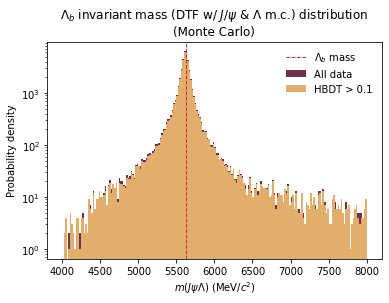

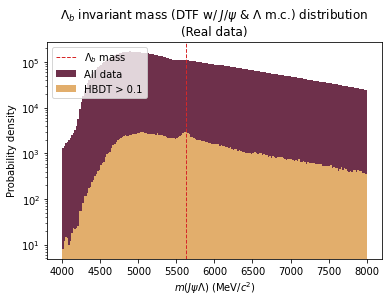

In [31]:
mass_range = (4000, 8000)
bin_number = 200
basic_filename = 'lambdab_before_after_soft'

## MC plot
plot_filename = 'MC_' + basic_filename

plt.hist(df_mc[inv_mass_variable], color=plum,
         bins=bin_number, range=mass_range, label='All data')
plt.hist(df_mc.loc[hbdt_cut_mc, inv_mass_variable], color=apricot,
         bins=bin_number, range=mass_range, label=soft_threshold_label)

if show_grid:
    plt.grid()

plt.yscale('log')
plt.xlabel("$m(J\psi \Lambda)$ (MeV/$c^2$)")
plt.ylabel('Probability density')
plt.title(inv_mass_variable_title + " distribution" + '\n(Monte Carlo)')
plt.axvline(lambdab_pdg_mass, color='tab:red', linestyle='--', linewidth='1', label='$\Lambda_b$ mass')
plt.legend(frameon=False)
if save_plots:
    plt.savefig(plot_directory + plot_filename + '.pdf', bbox_inches='tight')
plt.show()

## Data plots
plot_filename = 'Data_' + basic_filename

plt.hist(df_data[inv_mass_variable], color=plum,
         bins=bin_number, range=mass_range, label='All data')
plt.hist(df_data.loc[hbdt_cut_data, inv_mass_variable], color=apricot,
         bins=bin_number, range=mass_range, label=soft_threshold_label)

if show_grid:
    plt.grid()

plt.yscale('log')
plt.xlabel("$m(J\psi \Lambda)$ (MeV/$c^2$)")
plt.ylabel('Probability density')

if show_titles:
    plt.title(inv_mass_variable_title + " distribution" + '\n(Real data)')
plt.axvline(lambdab_pdg_mass, color='tab:red', linestyle='--', linewidth='1', label='$\Lambda_b$ mass')
plt.legend()
if save_plots:
    plt.savefig(plot_directory + plot_filename + '.pdf', bbox_inches='tight')
plt.show()

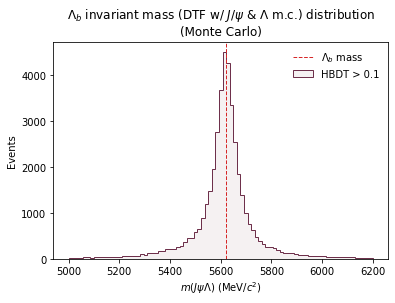

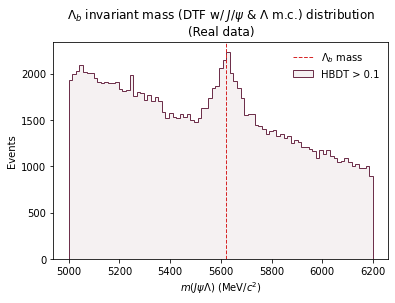

In [32]:
mass_range = (5000, 6200)
bin_number = 85
basic_filename = 'lambdab_after_soft_hist'

plot_filename = 'MC_' + basic_filename

MC_events, MC_bins, MC_patches = plt.hist(
    df_mc.loc[hbdt_cut_mc, inv_mass_variable],
    histtype='stepfilled', color=hex_to_rgba(lightplum,0.1), edgecolor=plum,
    bins=bin_number, range=mass_range, label=soft_threshold_label)

if show_grid:
    plt.grid()
#plt.yscale('log')
plt.xlabel("$m(J\psi \Lambda)$ (MeV/$c^2$)")
plt.ylabel('Events')
plt.title(inv_mass_variable_title + " distribution" + '\n(Monte Carlo)')
plt.axvline(lambdab_pdg_mass, color='tab:red', linestyle='--', linewidth='1', label='$\Lambda_b$ mass')
plt.legend(frameon=False)
if save_plots:
    plt.savefig(plot_directory + plot_filename + '.pdf', bbox_inches='tight')
plt.show()

plot_filename = 'Data_' + basic_filename

data_events, data_bins, data_patches = plt.hist(
    df_data.loc[hbdt_cut_data, inv_mass_variable],
    histtype='stepfilled', color=hex_to_rgba(lightplum,0.1), edgecolor=plum,
    bins=bin_number, range=mass_range, label=soft_threshold_label)

if show_grid:
    plt.grid()
plt.xlabel("$m(J\psi \Lambda)$ (MeV/$c^2$)")
plt.ylabel('Events')

if show_titles:
    plt.title(inv_mass_variable_title + " distribution" + '\n(Real data)')
plt.axvline(lambdab_pdg_mass, color='tab:red', linestyle='--', linewidth='1', label='$\Lambda_b$ mass')
plt.legend(frameon=False)
if save_plots:
    plt.savefig(plot_directory + plot_filename + '.pdf', bbox_inches='tight')
plt.show()

# First soft threshold fit
This is used to extract $s_0$ and $b_0$. Basically first we fit the MC alone, then fix all parameters bar normalization in the signal plus background fit.

In [33]:
## Almost zero, but not quite
epsilon = 1e-15

## Double crystal ball parameter dictionary
sig_func = {
     'param_names' : [r'S'  , r'mu' , r'sigma', r'alpha_1', r'n_1', r'alpha_2', r'n_2'],
     'p0'          : [6e4   , 5618   ,  35      , 0.7        ,  3.7  , 0.7        ,    3.7],
     'lb'          : [1e1   , 5000   ,   1      , 0.1        ,  1.5  , 0.1        ,    1.5],
     'ub'          : [1e6   , 6250   , 200      , 5          ,   10  , 5          ,     10]
}

## Dictionary variant for the constrained sig+bkg fit
sig_func_constrained = {
     'param_names' : [ r'S' ],
     'p0'          : [  200 ],
     'lb'          : [    0 ],
     'ub'          : [  1e9 ]
}

## Turn-on exponential dictionary
bkg_func = {
    'param_names' : [r'C',    r'm_0', r'a'],
    'p0' :          [0.09,    3500,   0.0008 ],
    'lb' :          [epsilon, 0,      epsilon],
    'ub' :          [1e9,     4999,   1      ]
}

## Monte Carlo fit (signal only)

In [34]:
MC_bin_midpoints = (MC_bins[1:] + MC_bins[:-1]) / 2

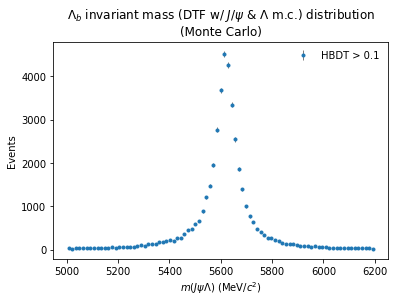

In [35]:
basic_filename = 'lambdab_after_soft_errorbar'
plot_filename = 'MC_' + basic_filename

plt.errorbar(x=MC_bin_midpoints,
             y=MC_events,
             yerr=np.sqrt(MC_events),
             linestyle='',
             marker='.',
             color='tab:blue', ecolor='k',
             elinewidth=0.5,
             label=soft_threshold_label)

if show_grid:
    plt.grid()
    
if show_titles:
    plt.title(inv_mass_variable_title + " distribution" + '\n(Monte Carlo)')

plt.xlabel("$m(J\psi \Lambda)$ (MeV/$c^2$)")
plt.ylabel('Events')
plt.legend(frameon=False)

if save_plots:
    plt.savefig(plot_directory + plot_filename + '.pdf', bbox_inches='tight')

plt.show()

In [36]:
MC_param_best, MC_param_covmatrix = optimize.curve_fit(
    f=fit_utils.crystal_ball_double_norm,
    xdata=MC_bin_midpoints,
    ydata=MC_events,
    p0=sig_func['p0'],
    sigma=np.sqrt(MC_events),
    bounds=(
        sig_func['lb'],
        sig_func['ub']
    )
)

In [37]:
MC_param_names = sig_func['param_names']
MC_param_error = np.sqrt(np.diag(MC_param_covmatrix))
for name, best, error in zip(MC_param_names, MC_param_best, MC_param_error):
    print(name, ":\t\t", best, "\t+-\t", error)

S :		 608167.6932812749 	+-	 3920.584174675433
mu :		 5619.477775647213 	+-	 0.45238700066979487
sigma :		 34.940243047784456 	+-	 0.828440775881107
alpha_1 :		 0.9161518765763416 	+-	 0.027709488235239856
n_1 :		 2.3608980550140948 	+-	 0.08266681643148978
alpha_2 :		 0.9713379894548301 	+-	 0.030191270749324595
n_2 :		 2.4574686381044133 	+-	 0.09543580867541605


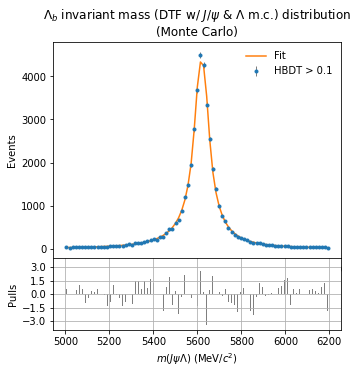

In [38]:
basic_filename = 'lambdab_soft_fit'
plot_filename = 'MC_' + basic_filename

## Invariant mas fit plot
fig = plt.figure(figsize=(5, 5))
frame_fit = fig.add_axes((.1,.3,.8,.6))
plt.errorbar(x=MC_bin_midpoints,
             y=MC_events,
             yerr=np.sqrt(MC_events),
             linestyle='',
             marker='.',
             color='tab:blue', ecolor='k',
             elinewidth=0.5,
             label=soft_threshold_label)

plt.plot(MC_bin_midpoints,
         fit_utils.crystal_ball_double_norm(MC_bin_midpoints, *MC_param_best),
         color='tab:orange',
         label='Fit')
if show_grid:
    plt.grid()
if show_titles:
    plt.title(inv_mass_variable_title + " distribution" + '\n(Monte Carlo)')

plt.xlabel("$m(J\psi \Lambda)$ (MeV/$c^2$)")
plt.ylabel('Events')
plt.legend(frameon=False)

## Pulls plot
frame_pulls = fig.add_axes((.1,.1,.8,.2))
plt.bar(x=MC_bin_midpoints,
        height=(MC_events - fit_utils.crystal_ball_double_norm(MC_bin_midpoints, *MC_param_best))/np.sqrt(MC_events),
        width=4,
        color='tab:gray')
plt.ylim((-4,4))
plt.grid()
plt.xlabel("$m(J\psi \Lambda)$ (MeV/$c^2$)")
plt.ylabel("Pulls")
plt.yticks([-3,-1.5,0,1.5,3])

if save_plots:
    plt.savefig(plot_directory + plot_filename + '.pdf', bbox_inches='tight')

plt.show()

## Run 2 data fit (signal and background)

In [39]:
(
    mu_constr,
    sigma_constr,
    alpha_1_constr,
    n_1_constr,
    alpha_2_constr,
    n_2_constr
) = MC_param_best[1:]

In [40]:
data_bin_midpoints = (data_bins[1:] + data_bins[:-1]) / 2

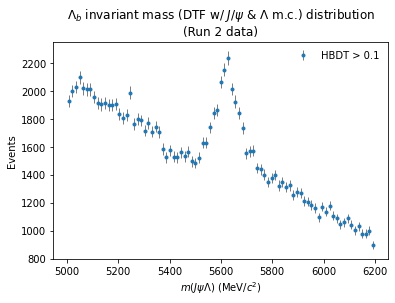

In [41]:
basic_filename = 'lambdab_after_soft_errorbar'
plot_filename = 'data_' + basic_filename

plt.errorbar(x=data_bin_midpoints,
             y=data_events,
             yerr=np.sqrt(data_events),
             linestyle='',
             marker='.',
             color='tab:blue', ecolor='k',
             elinewidth=0.5,
             label=soft_threshold_label)

if show_grid:
    plt.grid()
    
if show_titles:
    plt.title(inv_mass_variable_title + " distribution" + '\n(Run 2 data)')

plt.xlabel("$m(J\psi \Lambda)$ (MeV/$c^2$)")
plt.ylabel('Events')
plt.legend(frameon=False)

if save_plots:
    plt.savefig(plot_directory + plot_filename + '.pdf', bbox_inches='tight')

plt.show()

In [42]:
## This is the complete fit function, sum of:
## 1. A crystal_ball_double_norm with fixed parameters (to MC fit results) apart from normalization S.
## 2. A turn_on_exp with free parameters C (normalization), m_0 (turn-on mass), a (coefficient, as in exp[-a*x])
def sig_bkg_fit_function(x, S, C, m0, a):
    ## Fixed parameters
    mu = mu_constr
    sigma = sigma_constr
    alpha1 = alpha_1_constr
    n1 = n_1_constr
    alpha2 = alpha_2_constr
    n2 = n_2_constr
    
    signal = fit_utils.crystal_ball_double_norm(x, S, mu, sigma, alpha1, n1, alpha2, n2)
    background = fit_utils.turn_on_exp(x, C, m0, a)
    
    return signal + background

In [43]:
data_param_best, data_param_covmatrix = optimize.curve_fit(
    f=sig_bkg_fit_function,
    xdata=data_bin_midpoints,
    ydata=data_events,
    p0=sig_func_constrained['p0'] + bkg_func['p0'],
    sigma=np.sqrt(data_events),
    bounds=(
        sig_func_constrained['lb'] + bkg_func['lb'],
        sig_func_constrained['ub'] + bkg_func['ub']
    )
)

In [44]:
data_param_names = sig_func_constrained['param_names'] + bkg_func['param_names']
data_param_error = np.sqrt(np.diag(data_param_covmatrix))
for name, best, error in zip(data_param_names, data_param_best, data_param_error):
    print(name, ":\t\t", best, "\t+-\t", error)

S :		 109594.51552515103 	+-	 6113.685611406721
C :		 485.85444650010777 	+-	 1932.946650528564
m_0 :		 1294.844215302927 	+-	 8214.67380209509
a :		 0.0007197795726994654 	+-	 0.00022648049936278426


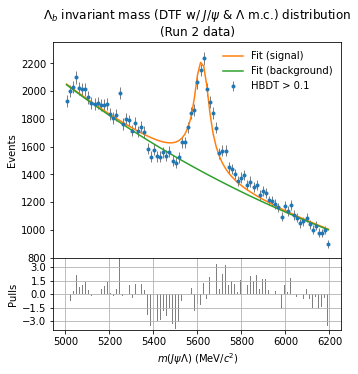

In [45]:
basic_filename = 'lambdab_soft_fit'
plot_filename = 'data_' + basic_filename

## Invariant mas fit plot
fig = plt.figure(figsize=(5, 5))
frame_fit = fig.add_axes((.1,.3,.8,.6))
plt.errorbar(x=data_bin_midpoints,
             y=data_events,
             yerr=np.sqrt(data_events),
             linestyle='',
             marker='.',
             color='tab:blue', ecolor='k',
             elinewidth=0.5,
             label=soft_threshold_label)

plt.plot(data_bin_midpoints,
         sig_bkg_fit_function(data_bin_midpoints, *data_param_best),
         color='tab:orange',
         label='Fit (signal)')
plt.plot(data_bin_midpoints,
         fit_utils.turn_on_exp(data_bin_midpoints, *data_param_best[1:]),
         color='tab:green',
         label='Fit (background)')
if show_grid:
    plt.grid()
if show_titles:
    plt.title(inv_mass_variable_title + " distribution" + '\n(Run 2 data)')

plt.xlabel("$m(J\psi \Lambda)$ (MeV/$c^2$)")
plt.ylabel('Events')
plt.legend(frameon=False)

## Pulls plot
frame_pulls = fig.add_axes((.1,.1,.8,.2))
plt.bar(x=data_bin_midpoints,
        height=(data_events - sig_bkg_fit_function(data_bin_midpoints, *data_param_best))/np.sqrt(data_events),
        width=4,
        color='tab:gray')
plt.ylim((-4,4))
plt.grid()
plt.xlabel("$m(J\psi \Lambda)$ (MeV/$c^2$)")
plt.ylabel("Pulls")
plt.yticks([-3,-1.5,0,1.5,3])

if save_plots:
    plt.savefig(plot_directory + plot_filename + '.pdf', bbox_inches='tight')

plt.show()

# Optimize the threshold

This notebook optimizes the threshold for the HBDT based on the figure of merit of signal significance

\begin{equation}
\frac{s_i}{\sqrt{s_i+b_i}}
\end{equation}

To avoid biasing ourselves towards data fluctuation, we extract $s_0$ and $b_0$ from a fit for data passing a certain `soft_threshold`, then use HBDT efficiencies extracted from application to test data to evaluate

\begin{equation}
s_i=\frac{s_0 \varepsilon_i^s}{\varepsilon_0^s} \\
b_i=\frac{b_0 \varepsilon_i^b}{\varepsilon_0^b}
\end{equation}

## Extract $s_0$ and $b_0$
The proper way would be to integrate functions in the $\pm 3\sigma$ region. We sum the fit function values in the bin midpoints within said region. Not as clean, let's hope it suffices.

In [46]:
S, C, m0, a = data_param_best

lower_integration_limit = mu_constr - 3 * sigma_constr
upper_integration_limit = mu_constr + 3 * sigma_constr

print("Integration interval:", ('{0:.5g}'. format(lower_integration_limit), '{0:.5g}'. format(upper_integration_limit)))

Integration interval: ('5514.7', '5724.3')


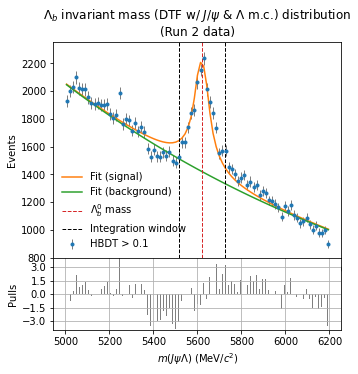

In [47]:
basic_filename = 'lambdab_soft_fit_window'
plot_filename = 'data_' + basic_filename

## Invariant mas fit plot
fig = plt.figure(figsize=(5, 5))
frame_fit = fig.add_axes((.1,.3,.8,.6))
plt.errorbar(x=data_bin_midpoints,
             y=data_events,
             yerr=np.sqrt(data_events),
             linestyle='',
             marker='.',
             color='tab:blue', ecolor='k',
             elinewidth=0.5,
             label=soft_threshold_label)

plt.plot(data_bin_midpoints,
         sig_bkg_fit_function(data_bin_midpoints, *data_param_best),
         color='tab:orange',
         label='Fit (signal)')
plt.plot(data_bin_midpoints,
         fit_utils.turn_on_exp(data_bin_midpoints, *data_param_best[1:]),
         color='tab:green',
         label='Fit (background)')
plt.axvline(lambdab_pdg_mass, linestyle='--', color='tab:red', linewidth=1, label='$\Lambda_b^0$ mass')
plt.axvline(lower_integration_limit, linestyle='--', color='k', linewidth=1)
plt.axvline(upper_integration_limit, linestyle='--', color='k', linewidth=1, label='Integration window')
if show_grid:
    plt.grid()
if show_titles:
    plt.title(inv_mass_variable_title + " distribution" + '\n(Run 2 data)')

plt.xlabel("$m(J\psi \Lambda)$ (MeV/$c^2$)")
plt.ylabel('Events')
plt.legend(frameon=False)

## Pulls plot
frame_pulls = fig.add_axes((.1,.1,.8,.2))
plt.bar(x=data_bin_midpoints,
        height=(data_events - sig_bkg_fit_function(data_bin_midpoints, *data_param_best))/np.sqrt(data_events),
        width=4,
        color='tab:gray')
plt.ylim((-4,4))
plt.grid()
plt.xlabel("$m(J\psi \Lambda)$ (MeV/$c^2$)")
plt.ylabel("Pulls")
plt.yticks([-3,-1.5,0,1.5,3])

if save_plots:
    plt.savefig(plot_directory + plot_filename + '.pdf', bbox_inches='tight')

plt.show()

In [48]:
integration_window = (data_bin_midpoints >= lower_integration_limit) & (data_bin_midpoints <= upper_integration_limit)

s0 = sum(fit_utils.crystal_ball_double_norm(
    data_bin_midpoints[integration_window],
    S, mu_constr, sigma_constr, alpha_1_constr, n_1_constr, alpha_2_constr, n_2_constr
))
b0 = sum(fit_utils.turn_on_exp(data_bin_midpoints[integration_window], C, m0, a))

print("s0 =", s0, "\nb0 =", b0)

s0 = 5797.327163696289 
b0 = 21398.678344726562


## Compute HBDT efficiencies from test data

In [49]:
input_dir = repo_dir + '/data/'
input_test = input_dir + 'test_dataset_' +  dataset_type + '.h5'

In [50]:
df_test = pd.read_hdf(input_test, 'LHCb_Test')

In [51]:
test_HBDT_input = df_test.loc[:, features].to_numpy()
test_HBDT_classes = df_test.loc[:, 'TYPE'].to_numpy()

In [52]:
test_HBDT_predicted_classes = HBDT.predict_proba(test_HBDT_input)[:,1]

In [53]:
false_positives, true_positives, roc_thresholds = metrics.roc_curve(test_HBDT_classes, test_HBDT_predicted_classes)

In [54]:
df_thres_efficiencies = pd.DataFrame(
    {
        'threshold': roc_thresholds,
        'sig_eff': true_positives,
        'bkg_eff': false_positives
    }
)

df_thres_efficiencies.sort_values(by='threshold', inplace=True)

try:
    del(df_test)
except NameError:
    pass

df_thres_efficiencies

,threshold,sig_eff,bkg_eff
5547,3.367856e-07,1.000000,1.000000
5546,9.915494e-06,1.000000,0.904982
5545,9.915985e-06,1.000000,0.904978
5544,1.411055e-05,1.000000,0.864239
5543,1.411070e-05,1.000000,0.864234
...,...,...,...
4,9.801999e-01,0.018704,0.000002
3,9.831988e-01,0.011644,0.000002
2,9.833728e-01,0.011644,0.000000
1,9.987286e-01,0.000124,0.000000


To use the figure of merit we need to know the **signal/background efficiencies** for the preliminary `soft_threshold` cut we used. Generally speaking we won't have the exact value, but we can get the next best thing: the efficiencies for the **closest threshold** computed in the ROC score.

In [55]:
## Outputs a tuple: threshold, signal efficiency, background efficiency
## The threshold is the closest to the soft_threshold variable
soft_thres_eff = df_thres_efficiencies.iloc[
    (df_thres_efficiencies['threshold'] - soft_threshold).abs().argsort()[:1]
].to_numpy()[0]

soft_signal_eff = soft_thres_eff[1]
soft_bkg_eff = soft_thres_eff[2]

In [56]:
## The figure of merit: s and b are signal and background rates respectively
def signal_significance(s, b):
    return s / np.sqrt(s + b)

Now we can compute the signal significance for each threshold!

In [57]:
df_thres_efficiencies['projected_sig_evts'] = s0 * df_thres_efficiencies['sig_eff'] / soft_signal_eff
df_thres_efficiencies['projected_bkg_evts'] = b0 * df_thres_efficiencies['bkg_eff'] / soft_bkg_eff
df_thres_efficiencies['sig_significance'] = signal_significance(
    df_thres_efficiencies['projected_sig_evts'],
    df_thres_efficiencies['projected_bkg_evts'])

df_thres_efficiencies

,threshold,sig_eff,bkg_eff,projected_sig_evts,projected_bkg_evts,sig_significance
5547,3.367856e-07,1.000000,1.000000,6418.242210,1.478226e+06,5.267504
5546,9.915494e-06,1.000000,0.904982,6418.242210,1.337769e+06,5.535875
5545,9.915985e-06,1.000000,0.904978,6418.242210,1.337762e+06,5.535890
5544,1.411055e-05,1.000000,0.864239,6418.242210,1.277540e+06,5.664227
5543,1.411070e-05,1.000000,0.864234,6418.242210,1.277533e+06,5.664243
...,...,...,...,...,...,...
4,9.801999e-01,0.018704,0.000002,120.048876,3.623210e+00,10.794990
3,9.831988e-01,0.011644,0.000002,74.732413,3.623210e+00,8.442555
2,9.833728e-01,0.011644,0.000000,74.732413,0.000000e+00,8.644791
1,9.987286e-01,0.000124,0.000000,0.795026,0.000000e+00,0.891642


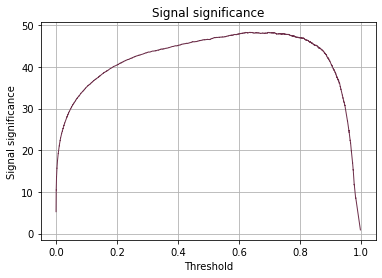

In [58]:
plot_filename = 'signal_significance'

plt.plot(df_thres_efficiencies['threshold'],
         df_thres_efficiencies['sig_significance'],
         color=plum, linewidth=1)

if show_titles:
    plt.title("Signal significance")

plt.xlabel("Threshold")
plt.ylabel("Signal significance")

plt.grid()

if save_plots:
    plt.savefig(plot_directory + plot_filename + '.pdf', bbox_inches='tight')
plt.show()

In [59]:
df_thres_efficiencies.sort_values(by='sig_significance', ascending=False)

,threshold,sig_eff,bkg_eff,projected_sig_evts,projected_bkg_evts,sig_significance
1316,6.375185e-01,0.634089,0.002042,4069.736389,3.018134e+03,48.340195
1320,6.370084e-01,0.634461,0.002049,4072.121466,3.029004e+03,48.323362
1330,6.361833e-01,0.635575,0.002061,4079.276697,3.047120e+03,48.322365
1318,6.372630e-01,0.634213,0.002047,4070.531415,3.025380e+03,48.322234
1328,6.362612e-01,0.635328,0.002059,4077.686646,3.043496e+03,48.321207
...,...,...,...,...,...,...
5545,9.915985e-06,1.000000,0.904978,6418.242210,1.337762e+06,5.535890
5546,9.915494e-06,1.000000,0.904982,6418.242210,1.337769e+06,5.535875
5547,3.367856e-07,1.000000,1.000000,6418.242210,1.478226e+06,5.267504
1,9.987286e-01,0.000124,0.000000,0.795026,0.000000e+00,0.891642


In [60]:
best_threshold_series = df_thres_efficiencies.loc[df_thres_efficiencies['sig_significance'].idxmax()]
best_threshold_series

threshold                0.637519
sig_eff                  0.634089
bkg_eff                  0.002042
projected_sig_evts    4069.736389
projected_bkg_evts    3018.133942
sig_significance        48.340195
Name: 1316, dtype: float64

## Check performance of the best threshold

In [61]:
hard_threshold = best_threshold_series['threshold']

hbdt_hardcut_mc = df_mc['HBDT'] > hard_threshold
hbdt_hardcut_data = df_data['HBDT'] > hard_threshold
hard_threshold_label = "HBDT > " + str(hard_threshold)[:6]

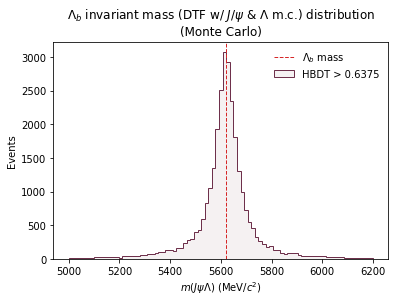

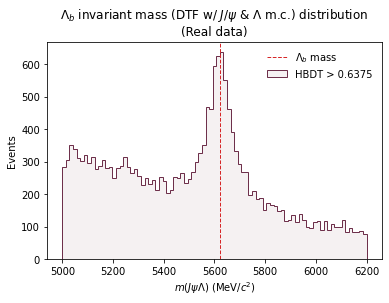

In [62]:
mass_range = (5000, 6200)
bin_number = 85
basic_filename = 'lambdab_after_hard_hist'

plot_filename = 'MC_' + basic_filename

MC_events, MC_bins, MC_patches = plt.hist(
    df_mc.loc[hbdt_hardcut_mc, inv_mass_variable],
    histtype='stepfilled', color=hex_to_rgba(lightplum,0.1), edgecolor=plum,
    bins=bin_number, range=mass_range, label=hard_threshold_label)

if show_grid:
    plt.grid()
#plt.yscale('log')
plt.xlabel("$m(J\psi \Lambda)$ (MeV/$c^2$)")
plt.ylabel('Events')
plt.title(inv_mass_variable_title + " distribution" + '\n(Monte Carlo)')
plt.axvline(lambdab_pdg_mass, color='tab:red', linestyle='--', linewidth='1', label='$\Lambda_b$ mass')
plt.legend(frameon=False)
if save_plots:
    plt.savefig(plot_directory + plot_filename + '.pdf', bbox_inches='tight')
plt.show()

plot_filename = 'Data_' + basic_filename

data_events, data_bins, data_patches = plt.hist(
    df_data.loc[hbdt_hardcut_data, inv_mass_variable],
    histtype='stepfilled', color=hex_to_rgba(lightplum,0.1), edgecolor=plum,
    bins=bin_number, range=mass_range, label=hard_threshold_label)

if show_grid:
    plt.grid()
plt.xlabel("$m(J\psi \Lambda)$ (MeV/$c^2$)")
plt.ylabel('Events')

if show_titles:
    plt.title(inv_mass_variable_title + " distribution" + '\n(Real data)')
plt.axvline(lambdab_pdg_mass, color='tab:red', linestyle='--', linewidth='1', label='$\Lambda_b$ mass')
plt.legend(frameon=False)
if save_plots:
    plt.savefig(plot_directory + plot_filename + '.pdf', bbox_inches='tight')
plt.show()

In [63]:
MC_bin_midpoints = (MC_bins[1:] + MC_bins[:-1]) / 2

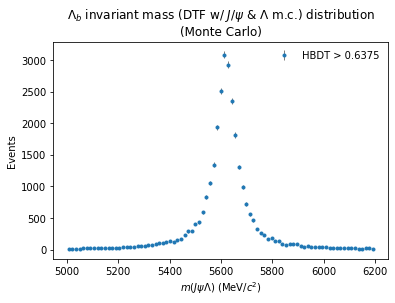

In [64]:
basic_filename = 'lambdab_after_hard_errorbar'
plot_filename = 'MC_' + basic_filename

plt.errorbar(x=MC_bin_midpoints,
             y=MC_events,
             yerr=np.sqrt(MC_events),
             linestyle='',
             marker='.',
             color='tab:blue', ecolor='k',
             elinewidth=0.5,
             label=hard_threshold_label)

if show_grid:
    plt.grid()
    
if show_titles:
    plt.title(inv_mass_variable_title + " distribution" + '\n(Monte Carlo)')

plt.xlabel("$m(J\psi \Lambda)$ (MeV/$c^2$)")
plt.ylabel('Events')
plt.legend(frameon=False)

if save_plots:
    plt.savefig(plot_directory + plot_filename + '.pdf', bbox_inches='tight')

plt.show()

In [65]:
MC_param_best, MC_param_covmatrix = optimize.curve_fit(
    f=fit_utils.crystal_ball_double_norm,
    xdata=MC_bin_midpoints,
    ydata=MC_events,
    p0=sig_func['p0'],
    sigma=np.sqrt(MC_events),
    bounds=(
        sig_func['lb'],
        sig_func['ub']
    )
)

In [66]:
MC_param_names = sig_func['param_names']
MC_param_error = np.sqrt(np.diag(MC_param_covmatrix))
for name, best, error in zip(MC_param_names, MC_param_best, MC_param_error):
    print(name, ":\t\t", best, "\t+-\t", error)

S :		 412318.24054623203 	+-	 3226.3681606054033
mu :		 5619.877015055931 	+-	 0.5506808313629395
sigma :		 37.00680828538494 	+-	 0.9538489402918966
alpha_1 :		 0.9796010123926131 	+-	 0.034646202672553056
n_1 :		 2.459336076234071 	+-	 0.11348712782922529
alpha_2 :		 1.0100869136831003 	+-	 0.03605236205111918
n_2 :		 2.5835962747661414 	+-	 0.13093934575967348


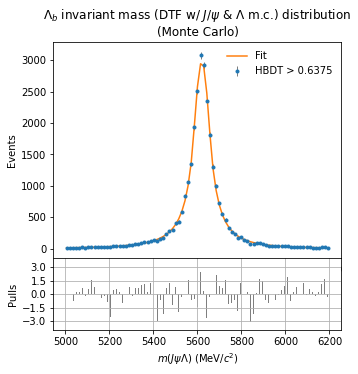

In [67]:
basic_filename = 'lambdab_hard_fit'
plot_filename = 'MC_' + basic_filename

## Invariant mas fit plot
fig = plt.figure(figsize=(5, 5))
frame_fit = fig.add_axes((.1,.3,.8,.6))
plt.errorbar(x=MC_bin_midpoints,
             y=MC_events,
             yerr=np.sqrt(MC_events),
             linestyle='',
             marker='.',
             color='tab:blue', ecolor='k',
             elinewidth=0.5,
             label=hard_threshold_label)

plt.plot(MC_bin_midpoints,
         fit_utils.crystal_ball_double_norm(MC_bin_midpoints, *MC_param_best),
         color='tab:orange',
         label='Fit')
if show_grid:
    plt.grid()
if show_titles:
    plt.title(inv_mass_variable_title + " distribution" + '\n(Monte Carlo)')

plt.xlabel("$m(J\psi \Lambda)$ (MeV/$c^2$)")
plt.ylabel('Events')
plt.legend(frameon=False)

## Pulls plot
frame_pulls = fig.add_axes((.1,.1,.8,.2))
plt.bar(x=MC_bin_midpoints,
        height=(MC_events - fit_utils.crystal_ball_double_norm(MC_bin_midpoints, *MC_param_best))/np.sqrt(MC_events),
        width=4,
        color='tab:gray')
plt.ylim((-4,4))
plt.grid()
plt.xlabel("$m(J\psi \Lambda)$ (MeV/$c^2$)")
plt.ylabel("Pulls")
plt.yticks([-3,-1.5,0,1.5,3])

if save_plots:
    plt.savefig(plot_directory + plot_filename + '.pdf', bbox_inches='tight')

plt.show()

In [68]:
(
    mu_constr,
    sigma_constr,
    alpha_1_constr,
    n_1_constr,
    alpha_2_constr,
    n_2_constr
) = MC_param_best[1:]

In [69]:
data_bin_midpoints = (data_bins[1:] + data_bins[:-1]) / 2

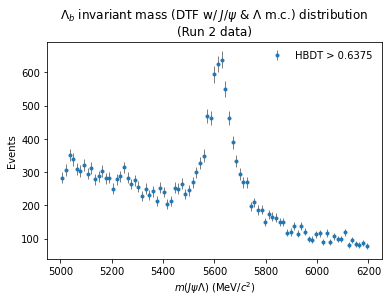

In [70]:
basic_filename = 'lambdab_after_soft_errorbar'
plot_filename = 'data_' + basic_filename

plt.errorbar(x=data_bin_midpoints,
             y=data_events,
             yerr=np.sqrt(data_events),
             linestyle='',
             marker='.',
             color='tab:blue', ecolor='k',
             elinewidth=0.5,
             label=hard_threshold_label)

if show_grid:
    plt.grid()
    
if show_titles:
    plt.title(inv_mass_variable_title + " distribution" + '\n(Run 2 data)')

plt.xlabel("$m(J\psi \Lambda)$ (MeV/$c^2$)")
plt.ylabel('Events')
plt.legend(frameon=False)

if save_plots:
    plt.savefig(plot_directory + plot_filename + '.pdf', bbox_inches='tight')

plt.show()

In [71]:
## This is the complete fit function, sum of:
## 1. A crystal_ball_double_norm with fixed parameters (to MC fit results) apart from normalization S.
## 2. A turn_on_exp with free parameters C (normalization), m_0 (turn-on mass), a (coefficient, as in exp[-a*x])
def sig_bkg_fit_function(x, S, C, m0, a):
    ## Fixed parameters
    mu = mu_constr
    sigma = sigma_constr
    alpha1 = alpha_1_constr
    n1 = n_1_constr
    alpha2 = alpha_2_constr
    n2 = n_2_constr
    
    signal = fit_utils.crystal_ball_double_norm(x, S, mu, sigma, alpha1, n1, alpha2, n2)
    background = fit_utils.turn_on_exp(x, C, m0, a)
    
    return signal + background

In [72]:
data_param_best, data_param_covmatrix = optimize.curve_fit(
    f=sig_bkg_fit_function,
    xdata=data_bin_midpoints,
    ydata=data_events,
    p0=sig_func_constrained['p0'] + bkg_func['p0'],
    sigma=np.sqrt(data_events),
    bounds=(
        sig_func_constrained['lb'] + bkg_func['lb'],
        sig_func_constrained['ub'] + bkg_func['ub']
    )
)

In [73]:
data_param_names = sig_func_constrained['param_names'] + bkg_func['param_names']
data_param_error = np.sqrt(np.diag(data_param_covmatrix))
for name, best, error in zip(data_param_names, data_param_best, data_param_error):
    print(name, ":\t\t", best, "\t+-\t", error)

S :		 67762.85051272121 	+-	 1943.0967043185613
C :		 32.53210008199044 	+-	 2.7801029974979765
m_0 :		 4534.338594042602 	+-	 157.20253470174055
a :		 0.001687885227429253 	+-	 9.897086456774668e-05


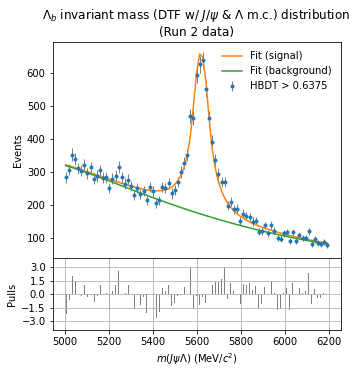

In [74]:
basic_filename = 'lambdab_hard_fit'
plot_filename = 'data_' + basic_filename

## Invariant mas fit plot
fig = plt.figure(figsize=(5, 5))
frame_fit = fig.add_axes((.1,.3,.8,.6))
plt.errorbar(x=data_bin_midpoints,
             y=data_events,
             yerr=np.sqrt(data_events),
             linestyle='',
             marker='.',
             color='tab:blue', ecolor='k',
             elinewidth=0.5,
             label=hard_threshold_label)

plt.plot(data_bin_midpoints,
         sig_bkg_fit_function(data_bin_midpoints, *data_param_best),
         color='tab:orange',
         label='Fit (signal)')
plt.plot(data_bin_midpoints,
         fit_utils.turn_on_exp(data_bin_midpoints, *data_param_best[1:]),
         color='tab:green',
         label='Fit (background)')
if show_grid:
    plt.grid()
if show_titles:
    plt.title(inv_mass_variable_title + " distribution" + '\n(Run 2 data)')

plt.xlabel("$m(J\psi \Lambda)$ (MeV/$c^2$)")
plt.ylabel('Events')
plt.legend(frameon=False)

## Pulls plot
frame_pulls = fig.add_axes((.1,.1,.8,.2))
plt.bar(x=data_bin_midpoints,
        height=(data_events - sig_bkg_fit_function(data_bin_midpoints, *data_param_best))/np.sqrt(data_events),
        width=4,
        color='tab:gray')
plt.ylim((-4,4))
plt.grid()
plt.xlabel("$m(J\psi \Lambda)$ (MeV/$c^2$)")
plt.ylabel("Pulls")
plt.yticks([-3,-1.5,0,1.5,3])

if save_plots:
    plt.savefig(plot_directory + plot_filename + '.pdf', bbox_inches='tight')

plt.show()

In [75]:
S, C, m0, a = data_param_best

lower_integration_limit = mu_constr - 3 * sigma_constr
upper_integration_limit = mu_constr + 3 * sigma_constr

print("Integration interval:", ('{0:.5g}'. format(lower_integration_limit), '{0:.5g}'. format(upper_integration_limit)))

Integration interval: ('5508.9', '5730.9')


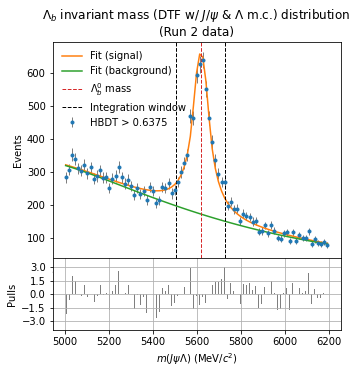

In [76]:
basic_filename = 'lambdab_hard_fit_window'
plot_filename = 'data_' + basic_filename

## Invariant mas fit plot
fig = plt.figure(figsize=(5, 5))
frame_fit = fig.add_axes((.1,.3,.8,.6))
plt.errorbar(x=data_bin_midpoints,
             y=data_events,
             yerr=np.sqrt(data_events),
             linestyle='',
             marker='.',
             color='tab:blue', ecolor='k',
             elinewidth=0.5,
             label=hard_threshold_label)

plt.plot(data_bin_midpoints,
         sig_bkg_fit_function(data_bin_midpoints, *data_param_best),
         color='tab:orange',
         label='Fit (signal)')
plt.plot(data_bin_midpoints,
         fit_utils.turn_on_exp(data_bin_midpoints, *data_param_best[1:]),
         color='tab:green',
         label='Fit (background)')
plt.axvline(lambdab_pdg_mass, linestyle='--', color='tab:red', linewidth=1, label='$\Lambda_b^0$ mass')
plt.axvline(lower_integration_limit, linestyle='--', color='k', linewidth=1)
plt.axvline(upper_integration_limit, linestyle='--', color='k', linewidth=1, label='Integration window')
if show_grid:
    plt.grid()
if show_titles:
    plt.title(inv_mass_variable_title + " distribution" + '\n(Run 2 data)')

plt.xlabel("$m(J\psi \Lambda)$ (MeV/$c^2$)")
plt.ylabel('Events')
plt.legend(frameon=False)

## Pulls plot
frame_pulls = fig.add_axes((.1,.1,.8,.2))
plt.bar(x=data_bin_midpoints,
        height=(data_events - sig_bkg_fit_function(data_bin_midpoints, *data_param_best))/np.sqrt(data_events),
        width=4,
        color='tab:gray')
plt.ylim((-4,4))
plt.grid()
plt.xlabel("$m(J\psi \Lambda)$ (MeV/$c^2$)")
plt.ylabel("Pulls")
plt.yticks([-3,-1.5,0,1.5,3])

if save_plots:
    plt.savefig(plot_directory + plot_filename + '.pdf', bbox_inches='tight')

plt.show()

In [77]:
integration_window = (data_bin_midpoints >= lower_integration_limit) & (data_bin_midpoints <= upper_integration_limit)

s = sum(fit_utils.crystal_ball_double_norm(
    data_bin_midpoints[integration_window],
    S, mu_constr, sigma_constr, alpha_1_constr, n_1_constr, alpha_2_constr, n_2_constr
))
b = sum(fit_utils.turn_on_exp(data_bin_midpoints[integration_window], C, m0, a))

print('Hard threshold:', best_threshold_series['threshold'])
print("s =", s, "\nb =", b)
print("Projected signal significance:\t", best_threshold_series['sig_significance'])
print("Actual signal signifance:\t", signal_significance(s,b))

Hard threshold: 0.6375185018866044
s = 3741.6949310302734 
b = 2746.7018432617188
Projected signal significance:	 48.340194948726115
Actual signal signifance:	 46.45149283832596
